<a href="https://colab.research.google.com/github/charlesreid1/deep-learning-genomics/blob/master/keras_sklearn_cnn1d_dna_transcription_quantx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras and Sklearn for Deep Learning Genomics

## Variation 3: Quantile Transform

This notebook is a variation on a prior notebook, keras-sklearn_cnn1d_dna_transcription.ipynb ([Jupyter notebook](https://github.com/charlesreid1/deep-learning-genomics/blob/master/keras_cnn1d_dna_transcription.ipynb) or [Google CoLab notebook](https://colab.research.google.com/github/charlesreid1/deep-learning-genomics/blob/master/keras_cnn1d_dna_transcription.ipynb#)). It continues with the example from a prior notebook, namely, the problem of predicting transcription factor binding sites in DNA. This type of neural network operates on 1D sequence data (DNA nucleotides), so we build a 1D convolutional neural network to perform classification of DNA (is this string of nucleotides a transcription factor binding site or not).

This notebook variation is to apply a quantile transform to the chromatin accessibility input data, which transforms the data to a space where the distribution of vaues is a uniform distribution between 0 and 1.

## Import Libraries

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
import os
import math
import numpy as np
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
import joblib

In [0]:
# sklearn

from sklearn.pipeline import Pipeline
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

In [4]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential, Model
from keras.layers import Flatten, Embedding, Dense, Dropout, Input, Concatenate
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.layers import LeakyReLU
import keras

Using TensorFlow backend.


In [0]:
seed = 1729
numpy.random.seed(seed)

## Define Useful Keras Metrics

In [0]:
# via https://github.com/keras-team/keras/issues/6507#issuecomment-322857357

import keras.backend as K

def precision(y_true, y_pred):
    # Calculate the precision
    # clip ensures we're between 0 and 1
    # round ensures we're either 0 or 1
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    # Calculate the recall
    # clip ensures we're between 0 and 1
    # round ensures we're either 0 or 1
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fvalue(y_true, y_pred):
    # Calculate the F-value
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0
    p = precision(y_true,y_pred)
    r = recall(y_true,y_pred)
    fvalue = (2 * p * r)/(p + r + K.epsilon())
    return fvalue


## Load Dataset

In [7]:
!git clone https://github.com/deepchem/DeepLearningLifeSciences.git

Cloning into 'DeepLearningLifeSciences'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 95 (delta 24), reused 85 (delta 17), pack-reused 0
Unpacking objects: 100% (95/95), done.


In [0]:
!ln -fs DeepLearningLifeSciences/Chapter06/{test*,train*,valid*} .

In [0]:
!ln -fs DeepLearningLifeSciences/Chapter06/chromatin.txt

In contrast to the prior example, which uses the already-provided splits of training, testing, and validation, we will load all of the data all at once into a single X and y pair and use sklearn to split the data into testing and training sets.

In [10]:
def load_all_data():
    
    # load chromatin accessibility data
    accessibility = {}
    for line in open('chromatin.txt','r'):
        fields = line.split()
        accessibility[fields[0]] = float(fields[1])
    
    # load training, validation, and testing sets
    for i,label in enumerate(['train','valid','test']):
        datadir = "%s_dataset"%(label)
        base_filename = "shard-0-%s.joblib"
        X_filename = os.path.join(datadir,base_filename%("X"))
        y_filename = os.path.join(datadir,base_filename%("y"))
        w_filename = os.path.join(datadir,base_filename%("w"))
        ids_filename = os.path.join(datadir,base_filename%("ids"))
        
        this_X = joblib.load(X_filename)
        this_y = joblib.load(y_filename)
        this_w = joblib.load(w_filename)
        this_ids = joblib.load(ids_filename)
        this_chromatin = np.array([accessibility[k] for k in this_ids])
        
        # add X and chromatin data
        if i>0:
            X = np.concatenate([X,this_X])
            chromatin = np.concatenate([chromatin,this_chromatin])
            y = np.concatenate([y,this_y])
            w = np.concatenate([w,this_w])
            ids = np.concatenate([ids,this_ids])
        else:
            X = this_X
            chromatin = this_chromatin
            y = this_y
            w = this_w
            ids = this_ids
    
    # Don't transform chromatin data here
    # wait until we have our training/testing split
    
    return [X,chromatin], y, w, ids

[X,chromatin], y, w, ids = load_all_data()

print("Shape of all data:\n")

print("X shape:")
print(np.shape(X))

print("chromatin shape:")
print(np.shape(chromatin))

print("y shape:")
print(np.shape(y))

print("w shape:")
print(np.shape(w))

Shape of all data:

X shape:
(345271, 101, 4)
chromatin shape:
(345271,)
y shape:
(345271, 1)
w shape:
(345271, 1)


## Stratified K-Fold Validation

Now that we've loaded every data point into a single giant input list, we use scikit-learn to cut the data into training, testing, and validation parts.

We use the "normal" kernel initializer, which initializes perceptron weights using normally-distributed random numbers.

In [0]:
def create_chromatin():
    """Create and return a 1D convolutional neural net model.
    This model incorporates chromatin accessibility data.
    """
    # DNA sequence alphabet size
    n_features = 4
    seq_length = 101
    convolution_window = 10
    n_filters = 16
    
    # ----------------------------
    # Sequence branch of network
    # (1D DNA sequence)
    
    # Input
    seq_in = Input(shape=(seq_length,n_features))
    
    # Fencepost pattern
    seq = seq_in
    
    # Convolutional layers
    for i in range(3):
        seq = Conv1D(n_filters, convolution_window,
                    activation='relu',
                     padding='same',
                     kernel_initializer='normal')(seq)
        seq = Dropout(0.5)(seq)
    
    # Flatten to 1D
    seq = Flatten()(seq)
    
    # Assemble the sequential branch of network
    seq = keras.Model(inputs=seq_in, outputs=seq)
    
    # ---------------------------
    # Chromatin branch of network
    
    # Input
    chrom_input = Input(shape=(1,))
    
    # ---------------------------
    # Combine networks
    fin = keras.layers.concatenate([seq.output, chrom_input])
    fin = Dense(1,
                kernel_initializer='normal',
                activation='sigmoid')(fin)
    chrom_model = keras.Model(inputs=[seq.input,chrom_input], outputs=fin)
    
    # Compile model
    chrom_model.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       sample_weight_mode=None,
                       metrics=['accuracy',
                               precision,
                               recall,
                               fvalue])
    
    return chrom_model

## Performing Cross Validation Manually

To perform cross validation and incorporate sample weights for imbalanced classes (many more negative examples than positive examples), we can't use weights with sklearn directly, so we do cross-validation manually.

The [StratifiedKFold](https://sklearn.org/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) object can give us a set of k testing/training sets by using the `split()` method, which returns an iterator with the training/testing indices. This allows us to assemble all inputs (X and y, weights, labels, chromatin accessibility, etc.).

The [StratifiedShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html#sklearn.model_selection.StratifiedShuffleSplit) object also provides a split method.

In [12]:
n_epochs = 100
n_fold = 3
include_chromatin_data = True

# we can use either of these,
# but we'll opt for shuffle

kfold = StratifiedKFold(n_splits=n_fold, 
                        shuffle=True, 
                        random_state=seed)

shuffle = StratifiedShuffleSplit(n_splits=n_fold,
                                 train_size = 0.7,
                                 test_size = 0.3,
                                 random_state = seed)
transformers = []
models = []
fithists = []

for ifold, (train_ix, test_ix) in enumerate(shuffle.split(X,y)):
    
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]
    w_train, w_test = np.squeeze(w[train_ix]), np.squeeze(w[test_ix])
    chrom_train, chrom_test = np.squeeze(chromatin[train_ix]), np.squeeze(chromatin[test_ix])
    
    ########################################
    # Perform nonlinear transform
    quantx = QuantileTransformer(random_state=seed)
    chromx_train = quantx.fit_transform(chrom_train.reshape(-1,1))
    chromx_test = quantx.transform(chrom_test.reshape(-1,1))
    ########################################
    
    print("Training on fold %d..."%(ifold+1))
    
    # if we use the chromatin model, 
    # we need to provide the network
    # with a *list* of inputs
    
    if include_chromatin_data:
        model = create_chromatin()
        hist = model.fit([X_train,chromx_train], y_train,
                         sample_weight = w_train,
                         batch_size = 1000,
                         epochs = n_epochs,
                         verbose = 0,
                         validation_data=([X_test,chromx_test],y_test,w_test))
    else:
        model = create_baseline()
        hist = model.fit(X_train, y_train,
                         sample_weight = w_train,
                         batch_size = 1000,
                         epochs = n_epochs,
                         verbose = 0,
                         validation_data=(X_test,y_test,w_test))

    transformers.append(quantx)
    models.append(model)
    fithists.append(hist)
    
    print("Done")
    

Training on fold 1...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Done
Training on fold 2...
Done
Training on fold 3...
Done


In [13]:
print("Model results (validation):")
print("\n")
print("Loss (Mean):      %0.4f"%(np.mean([h.history['val_loss'] for h in fithists])))
print("Loss (Std):       %0.4f"%(np.std([h.history['val_loss'] for h in fithists])))
print("\n")
print("Accuracy (Mean):  %0.2f%%"%(100*np.mean([h.history['val_acc'] for h in fithists])))
print("Accuracy (Std):   %0.2f%%"%(100*np.std([h.history['val_acc'] for h in fithists])))
print("\n")
print("Precision (Mean): %0.2f%%"%(100*np.mean([h.history['val_precision'] for h in fithists])))
print("Precision (Std):  %0.2f%%"%(100*np.std([h.history['val_precision'] for h in fithists])))
print("\n")
print("Recall (Mean):    %0.2f%%"%(100*np.mean([h.history['val_recall'] for h in fithists])))
print("Recall (Std):     %0.2f%%"%(100*np.std([h.history['val_recall'] for h in fithists])))

Model results (validation):


Loss (Mean):      0.6425
Loss (Std):       0.0353


Accuracy (Mean):  41.44%
Accuracy (Std):   7.23%


Precision (Mean): 0.65%
Precision (Std):  0.07%


Recall (Mean):    88.83%
Recall (Std):     3.98%


In [0]:
def loss_rate_plot(hist, ax, label='',legend=False):
    ax.plot(hist.history['loss'])
    ax.plot(hist.history['val_loss'])
    if label=='':
        ax.set_title("Loss Rate", size=14)
    else:
        ax.set_title("Loss Rate (%s)"%(label), size=14)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Training interations')
    if legend:
        ax.legend(['Training', 'Validation'], loc='upper right')

def accuracy_rate_plot(hist,ax,label='',legend=False):
    ax.plot([j*100 for j in hist.history['acc']])
    ax.plot([j*100 for j in hist.history['val_acc']])
    if label=='':
        ax.set_title("Accuracy", size=14)
    else:
        ax.set_title("Accuracy (%s)"%(label), size=14)
    ax.set_ylabel('Accuracy %')
    ax.set_xlabel('Training iterations')
    if legend:
        ax.legend(['Training','Validation'], loc='lower right')

def precision_rate_plot(hist,ax,label='',legend=False):
    ax.plot([j*100 for j in hist.history['precision']])
    ax.plot([j*100 for j in hist.history['val_precision']])
    if label=='':
        ax.set_title("Precision", size=14)
    else:
        ax.set_title("Precision (%s)"%(label), size=14)
    ax.set_ylabel('Precision %')
    ax.set_xlabel('Training iterations')
    if legend:
        ax.legend(['Training','Validation'], loc='lower right')

def recall_rate_plot(hist,ax,label='',legend=False):
    ax.plot([j*100 for j in hist.history['recall']])
    ax.plot([j*100 for j in hist.history['val_recall']])
    if label=='':
        ax.set_title("Recall", size=14)
    else:
        ax.set_title("Recall (%s)"%(label), size=14)
    ax.set_ylabel('Recall %')
    ax.set_xlabel('Training iterations')
    if legend:
        ax.legend(['Training','Validation'], loc='lower right')

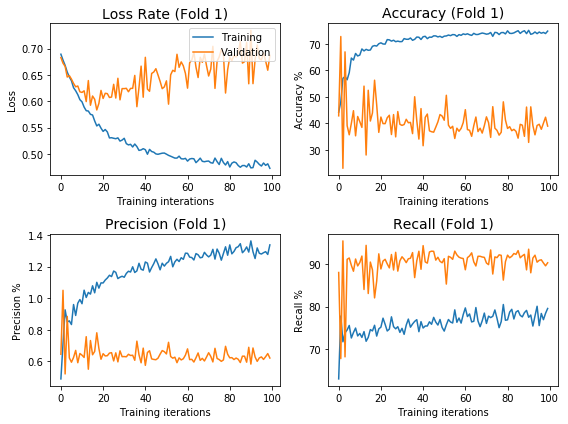

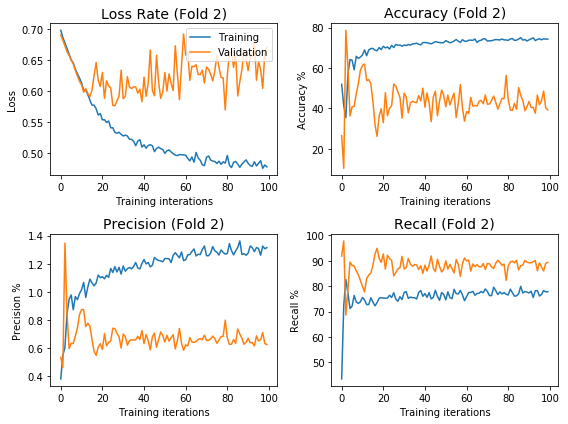

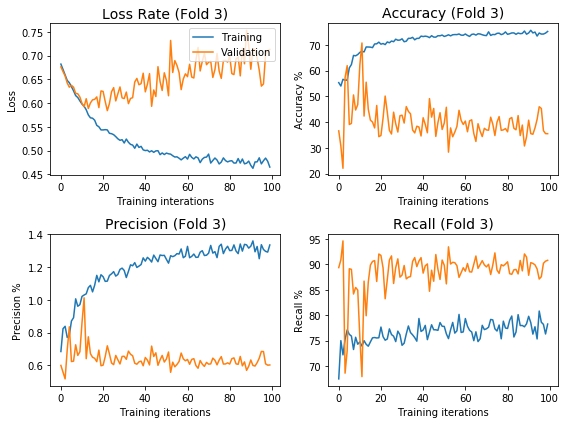

In [15]:
for i in range(shuffle.get_n_splits()):
    
    fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2, figsize=(8,6))

    loss_rate_plot(fithists[i],      ax1, legend=True, label="Fold %d"%(i+1))
    accuracy_rate_plot(fithists[i],  ax2, label="Fold %d"%(i+1))
    precision_rate_plot(fithists[i], ax3, label="Fold %d"%(i+1))
    recall_rate_plot(fithists[i],    ax4, label="Fold %d"%(i+1))

    fig.tight_layout()
    
plt.show()

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else ','
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

---------------
Fold 1:
Confusion matrix, without normalization
[[39947 63197]
 [   44   394]]
---------------
Fold 2:
Confusion matrix, without normalization
[[40325 62819]
 [   42   396]]
---------------
Fold 3:
Confusion matrix, without normalization
[[36382 66762]
 [   33   405]]


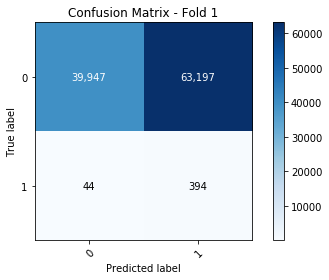

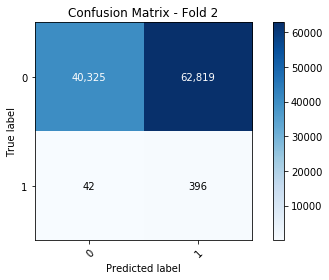

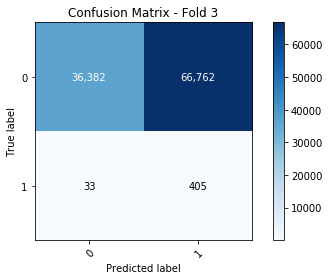

In [17]:
for ifold, (train_ix, test_ix) in enumerate(shuffle.split(X,y)):

    print("---------------")
    print("Fold %d:"%(ifold+1))
    
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]
    w_train, w_test = np.squeeze(w[train_ix]), np.squeeze(w[test_ix])
    chrom_train, chrom_test = chromatin[train_ix], chromatin[test_ix]
    
    transformer = transformers[ifold]
    
    ##########################
    # apply power transformer
    chromx_train = transformer.transform(chrom_train.reshape(-1,1))
    chromx_test  = transformer.transform(chrom_test.reshape(-1,1))
    ##########################
    
    model = models[ifold]
    
    if include_chromatin_data:
        y_test_pred = model.predict([X_test,chromx_test])
    else:
        y_test_pred = model.predict(X_test)
        
    y_test_pred = np.round(y_test_pred)

    ax = plot_confusion_matrix(y_test, y_test_pred, ['0','1'], title="Confusion Matrix - Fold %d"%(ifold+1))


Finally, we compute the ROC curve for all k models from the k-fold cross-validation and use those curves to assemble the mean and variance of the ROC curve at every point. See [ROC with cross validation example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html) in the sklearn documentation.

In [0]:
def plot_roc_curve(y_true, y_pred, weights):
    fpr, tpr, _ = roc_curve(y_true, y_pred)#, 
                            #sample_weight = weights)
    
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_true, y_pred))
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.plot([0,1],[0,1],'k--')
    ax.set_title("ROC Curve")
    plt.legend(loc='lower right')
    plt.show()
    
    fig.tight_layout()
    return ax

Working on fold 1...
Working on fold 2...
Working on fold 3...
Area under curve:
Mean: 0.6101
Std: 0.0047


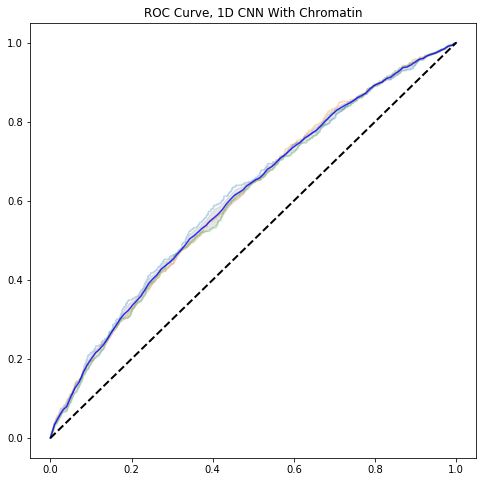

In [19]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

from scipy import interp

fig, ax = plt.subplots(1,1,figsize=(8,8))

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)

for ifold, (train_ix, test_ix) in enumerate(shuffle.split(X,y)):

    print("Working on fold %d..."%(ifold+1))
    
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]
    w_train, w_test = np.squeeze(w[train_ix]), np.squeeze(w[test_ix])
    chrom_train, chrom_test = chromatin[train_ix], chromatin[test_ix]
    
    model = models[ifold]
    
    if include_chromatin_data:
        y_test_pred = model.predict([X_test,chrom_test]).ravel()
    else:
        y_test_pred = model.predict(X_test).ravel()
        
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
    tprs.append(interp(mean_fpr,fpr,tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr,tpr)
    aucs.append(roc_auc)
    ax.plot(fpr,tpr, alpha=0.3)


mean_tpr = np.mean(tprs,axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b', alpha=0.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2)

ax.plot([0,1],[0,1],'--k',lw=2)

ax.set_title('ROC Curve, 1D CNN With Chromatin')

print("Area under curve:")
print("Mean: %0.4f"%(mean_auc))
print("Std: %0.4f"%(std_auc))

plt.show()

## Class Weights

Next we try replacing the weights that came with the data set with class weights. Let's review the imbalance in our data:

In [20]:
neg = np.sum(y==0)
pos = np.sum(y==1)
print("Negative examples: %d"%(neg))
print("Positive examples: %d"%(pos))
print("Percent positive: %0.2f%%"%(100*(pos/(pos+neg))))

Negative examples: 343811
Positive examples: 1460
Percent positive: 0.42%


We can use the `class_weight` module from sklearn to automatically compute class weights, which can be passed to keras when we fit our model to data.

In [21]:
from sklearn.utils import class_weight

classes = np.unique(y_train)
labels = np.squeeze(y_train)

weights = class_weight.compute_class_weight('balanced',classes,labels)

class_weights = {}
for c,w in zip(classes,weights):
    class_weights[c] = w
print(class_weights)

{0: 0.5021232657572496, 1: 118.2431506849315}


Now we re-fit the model to data, this time using the class weights from sklearn instead of the weights provided in the data files:

In [0]:
np.random.seed(seed)

In [23]:
n_epochs = 100
n_fold = 3
include_chromatin_data = True

shuffle = StratifiedShuffleSplit(n_splits=n_fold,
                                 train_size = 0.7,
                                 test_size = 0.3,
                                 random_state = seed)

transformers2 = []
models2 = []
fithists2 = []

for ifold, (train_ix, test_ix) in enumerate(shuffle.split(X,y)):
    
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]
    chrom_train, chrom_test = np.squeeze(chromatin[train_ix]), np.squeeze(chromatin[test_ix])
    
    ##################################################
    # Perform nonlinear transform
    quantx = QuantileTransformer(random_state=seed)
    chromx_train = quantx.fit_transform(chrom_train.reshape(-1,1))
    chromx_test = quantx.transform(chrom_test.reshape(-1,1))
    ##################################################
    
    print("Training on fold %d..."%(ifold+1))
    
    model = create_chromatin()
    hist = model.fit([X_train,chromx_train], y_train,
                     class_weight = class_weights,
                     batch_size = 1000,
                     epochs = n_epochs,
                     verbose = 0,
                     validation_data=([X_test,chromx_test],y_test))
    
    transformers2.append(quantx)
    models2.append(model)
    fithists2.append(hist)
    
    print("Done")

Training on fold 1...
Done
Training on fold 2...
Done
Training on fold 3...
Done


In [24]:
print("Model results (validation):")
print("\n")
print("Loss (Mean):      %0.4f"%(np.mean([h.history['val_loss'] for h in fithists2])))
print("Loss (Std):       %0.4f"%(np.std([h.history['val_loss'] for h in fithists2])))
print("\n")
print("Accuracy (Mean):  %0.2f%%"%(100*np.mean([h.history['val_acc'] for h in fithists2])))
print("Accuracy (Std):   %0.2f%%"%(100*np.std([h.history['val_acc'] for h in fithists2])))
print("\n")
print("Precision (Mean): %0.2f%%"%(100*np.mean([h.history['val_precision'] for h in fithists2])))
print("Precision (Std):  %0.2f%%"%(100*np.std([h.history['val_precision'] for h in fithists2])))
print("\n")
print("Recall (Mean):    %0.2f%%"%(100*np.mean([h.history['val_recall'] for h in fithists2])))
print("Recall (Std):     %0.2f%%"%(100*np.std([h.history['val_recall'] for h in fithists2])))

Model results (validation):


Loss (Mean):      0.8541
Loss (Std):       0.2855


Accuracy (Mean):  49.47%
Accuracy (Std):   17.71%


Precision (Mean): 0.85%
Precision (Std):  0.38%


Recall (Mean):    86.56%
Recall (Std):     7.13%


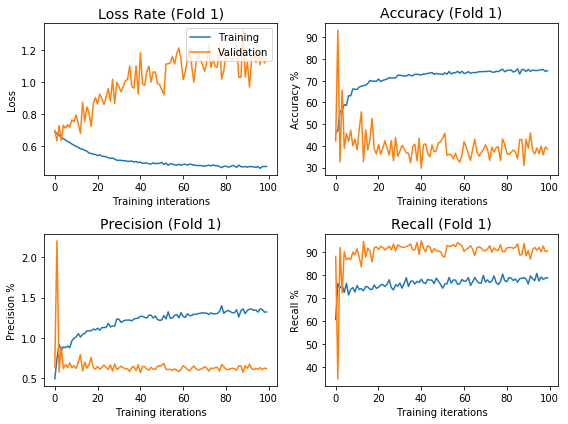

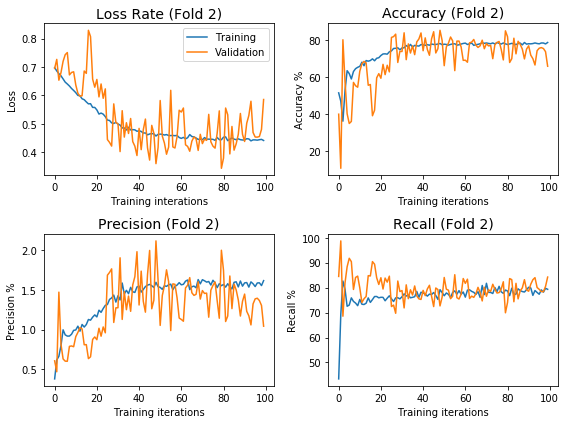

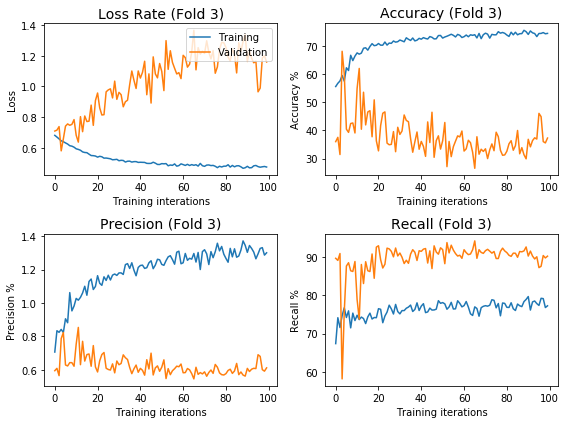

In [25]:
for i in range(shuffle.get_n_splits()):
    
    fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2, figsize=(8,6))

    loss_rate_plot(fithists2[i], ax1, legend=True, label="Fold %d"%(i+1))
    accuracy_rate_plot(fithists2[i], ax2, label="Fold %d"%(i+1))
    precision_rate_plot(fithists2[i], ax3, label="Fold %d"%(i+1))
    recall_rate_plot(fithists2[i], ax4, label="Fold %d"%(i+1))

    fig.tight_layout()
    
plt.show()

---------------
Fold 1:
Confusion matrix, without normalization
[[39493 63651]
 [   45   393]]
---------------
Fold 2:
Confusion matrix, without normalization
[[68036 35108]
 [   69   369]]
---------------
Fold 3:
Confusion matrix, without normalization
[[38246 64898]
 [   38   400]]


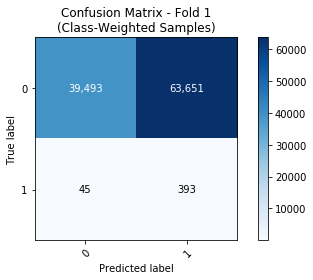

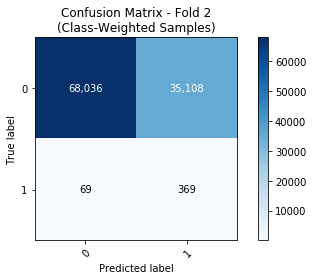

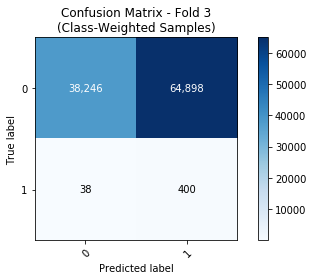

In [26]:
for ifold, (train_ix, test_ix) in enumerate(shuffle.split(X,y)):

    print("---------------")
    print("Fold %d:"%(ifold+1))
    
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]
    chrom_train, chrom_test = chromatin[train_ix], chromatin[test_ix]
    
    transformer = transformers2[ifold]
    
    chromx_train = transformer.transform(chrom_train.reshape(-1,1))
    chromx_test  = transformer.transform(chrom_test.reshape(-1,1))
    
    model = models2[ifold]
    
    y_test_pred = model.predict([X_test,chromx_test])
    
    y_test_pred = np.round(y_test_pred)

    ax = plot_confusion_matrix(y_test, y_test_pred, ['0','1'], title="Confusion Matrix - Fold %d\n(Class-Weighted Samples)"%(ifold+1))


The code below is similar to, but slightly modified from, the ROC plot above. It shows the same quantity: the ROC curves for all k models from the k-fold cross-validation, and the mean and standard deviation assembled from those models.

Working on fold 1...
Working on fold 2...
Working on fold 3...
Area under curve:
Mean: 0.8203
Std: 0.0262


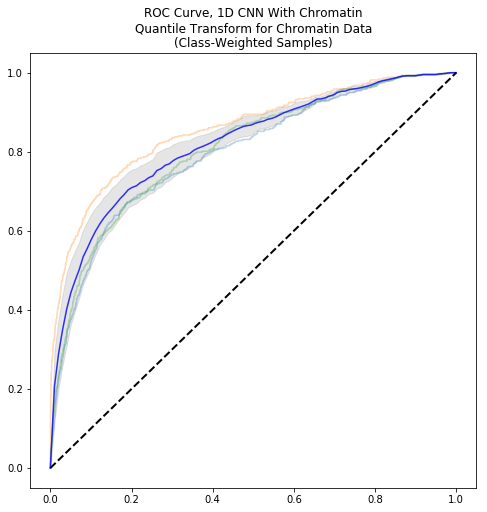

In [27]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

from scipy import interp

fig, ax = plt.subplots(1,1,figsize=(8,8))

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)

for ifold, (train_ix, test_ix) in enumerate(shuffle.split(X,y)):

    print("Working on fold %d..."%(ifold+1))
    
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]
    chrom_train, chrom_test = chromatin[train_ix], chromatin[test_ix]
    
    transformer = transformers2[ifold]
    
    chromx_train = transformer.transform(chrom_train.reshape(-1,1))
    chromx_test  = transformer.transform(chrom_test.reshape(-1,1))
    
    model = models2[ifold]
    
    y_test_pred = model.predict([X_test,chromx_test]).ravel()
        
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
    tprs.append(interp(mean_fpr,fpr,tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr,tpr)
    aucs.append(roc_auc)
    ax.plot(fpr,tpr, alpha=0.3)

    
mean_tpr = np.mean(tprs,axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b', alpha=0.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2)

ax.plot([0,1],[0,1],'--k',lw=2)

ax.set_title('ROC Curve, 1D CNN With Chromatin\nQuantile Transform for Chromatin Data\n(Class-Weighted Samples)')

print("Area under curve:")
print("Mean: %0.4f"%(mean_auc))
print("Std: %0.4f"%(std_auc))

plt.show()

# Analysis

We can see why relying solely on the ROC AUC is deceptive. The quantile transform has an ROC AUC of 0.8004, compared with 0.8101 for the power transform and 0.7737 without. However, looking at the confusion matrix, we can see that the model using quantile-transformed chromatin data has a high sensitivity to how the data is split into testing and training. It also dos a poor job of classification - it essentially classifies 2/3 of all input DNA seqences as binding sites.

For some of the splits into testing and training (the last two of the three folds), the training versus validation data (as with the power transform) have deviating behavior - when the measure decreases for testing, it increases for validation, and vice-versa.